In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving KDDTest+.txt to KDDTest+.txt
Saving KDDTrain+.txt to KDDTrain+.txt


In [ ]:
import os

# List all files in /content
print(os.listdir("/content"))


['.config', 'KDDTrain+.txt', 'KDDTest+.txt', 'sample_data']


In [ ]:
# Dataset field names
datacols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

# Load NSL_KDD train dataset
dfkdd_train = pd.read_table("/content/KDDTrain+.txt", sep=",", names=datacols) # change path to where the dataset is located.
dfkdd_train = dfkdd_train.iloc[:,:-1] # removes an unwanted extra field

# Load NSL_KDD test dataset
dfkdd_test = pd.read_table("/content/KDDTest+.txt", sep=",", names=datacols)
dfkdd_test = dfkdd_test.iloc[:,:-1]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# View train data
dfkdd_train.head(3)

# train set dimension
print('Train set dimension: {} rows, {} columns'.format(dfkdd_train.shape[0], dfkdd_train.shape[1]))

Train set dimension: 125973 rows, 42 columns


In [ ]:
# View test data
dfkdd_test.head(3)

# test set dimension
print('Test set dimension: {} rows, {} columns'.format(dfkdd_test.shape[0], dfkdd_test.shape[1]))

Test set dimension: 22544 rows, 42 columns


Data Preprocessing

In [ ]:
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

In [ ]:
# Apply attack class mappings to the dataset
dfkdd_train['attack_class'] = dfkdd_train['attack'].apply(lambda v: mapping[v])
dfkdd_test['attack_class'] = dfkdd_test['attack'].apply(lambda v: mapping[v])

In [ ]:
# Drop attack field from both train and test data
dfkdd_train.drop(['attack'], axis=1, inplace=True)
dfkdd_test.drop(['attack'], axis=1, inplace=True)

In [ ]:
# View top 3 train data
dfkdd_train.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,Normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,Normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal


In [ ]:
# Descriptive statistics
dfkdd_train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
print("Columns in dfkdd_train:", dfkdd_train.columns)
print("Columns in dfkdd_test:", dfkdd_test.columns)

Columns in dfkdd_train: Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'attack_class'],
      dtype='object')
Columns in dfkdd_test: Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land',

In [ ]:
# 'num_outbound_cmds' field has all 0 values. Hence, it will be removed from both train and test dataset since it is a redundant field.
dfkdd_train.drop(['num_outbound_cmds'], axis=1, inplace=True)
dfkdd_test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [ ]:
# Attack Class Distribution
attack_class_freq_train = dfkdd_train[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_test = dfkdd_test[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_train['frequency_percent_train'] = round((100 * attack_class_freq_train / attack_class_freq_train.sum()),2)
attack_class_freq_test['frequency_percent_test'] = round((100 * attack_class_freq_test / attack_class_freq_test.sum()),2)

attack_class_dist = pd.concat([attack_class_freq_train,attack_class_freq_test], axis=1)
attack_class_dist

,attack_class,frequency_percent_train,attack_class,frequency_percent_test
attack_class,,,,
Normal,67343,53.46,9711,43.08
DoS,45927,36.46,7458,33.08
Probe,11656,9.25,2421,10.74
R2L,995,0.79,2754,12.22
U2R,52,0.04,200,0.89


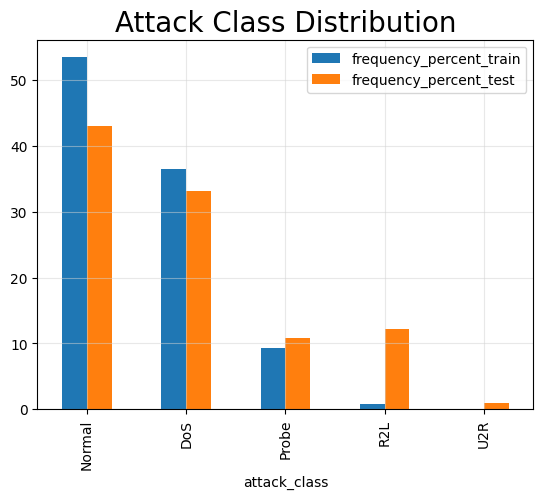

In [ ]:
# Attack class bar plot
plot = attack_class_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar");
plot.set_title("Attack Class Distribution", fontsize=20);
plot.grid(color='lightgray', alpha=0.5);

In [ ]:
dfkdd_train.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,Normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,Normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal


Scaling Numerical Attributes



In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance
cols = dfkdd_train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(dfkdd_train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(dfkdd_test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

Encoding of Categorical Attributes


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets
cattrain = dfkdd_train.select_dtypes(include=['object']).copy()
cattest = dfkdd_test.select_dtypes(include=['object']).copy()

# separate target column from encoded data
cat_Ytrain = dfkdd_train[['attack_class']].copy() # Extract 'attack_class' from the original dfkdd_train
cat_Ytest = dfkdd_test[['attack_class']].copy()   # Extract 'attack_class' from the original dfkdd_test

# drop 'attack_class' before encoding
cattrain = cattrain.drop(['attack_class'], axis=1)
cattest = cattest.drop(['attack_class'], axis=1)

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# Now you can proceed with the rest of your code
enctrain = traincat.copy()
enctest = testcat.copy()

Data Sampling


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# define columns and extract encoded train set for sampling
sc_traindf = dfkdd_train.select_dtypes(include=['float64','int64'])
refclasscol = pd.concat([sc_traindf, enctrain], axis=1).columns
refclass = np.concatenate((sc_train, enctrain.values), axis=1)
X = refclass

# reshape target column to 1D array shape
c, r = cat_Ytest.values.shape
y_test = cat_Ytest.values.reshape(c,)

c, r = cat_Ytrain.values.shape
y = cat_Ytrain.values.reshape(c,)

# apply the random over-sampling
ros = RandomOverSampler(random_state=42)
# Use fit_resample instead of fit_sample
X_res, y_res = ros.fit_resample(X, y)
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({'Normal': 67343, 'DoS': 45927, 'Probe': 11656, 'R2L': 995, 'U2R': 52})
Resampled dataset shape Counter({'Normal': 67343, 'DoS': 67343, 'R2L': 67343, 'Probe': 67343, 'U2R': 67343})


Feature Selection


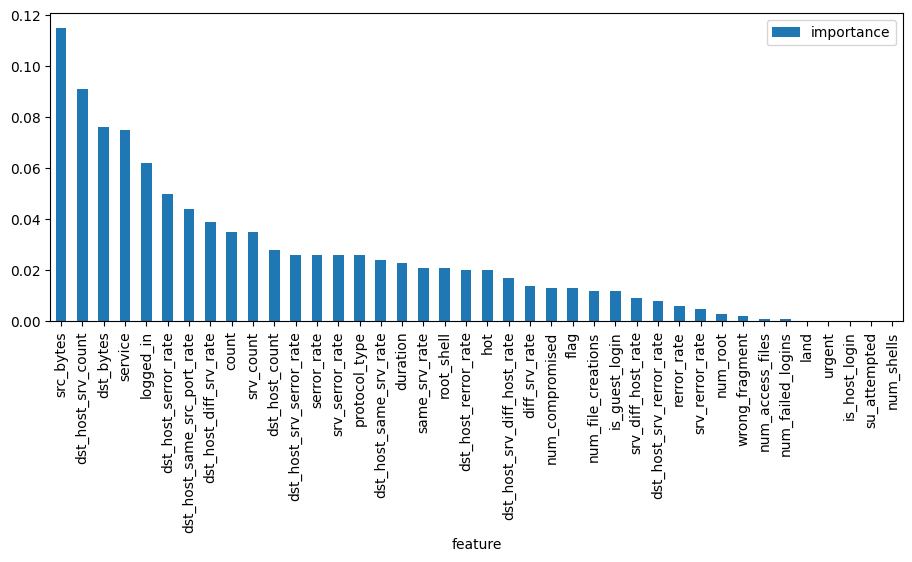

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(X_res, y_res);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':refclasscol,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [ ]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_res, y_res)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), refclasscol)]
selected_features = [v for i, v in feature_map if i==True]

In [ ]:
selected_features

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_serror_rate',
 'service']

In [ ]:
print(testcat.columns)
print(testcat.head())


Index(['protocol_type', 'service', 'flag'], dtype='object')
   protocol_type  service  flag
0              1       45     1
1              1       45     1
2              1       19     9
3              0       13     9
4              1       55     2


Dataset Partition


In [ ]:
# create test dataframe
# Ensure 'attack_class' is in either sc_testdf or testcat
#reftest = pd.concat([sc_testdf, testcat], axis=1)

from sklearn.preprocessing import LabelEncoder

# Initialize encoder
attack_encoder = LabelEncoder()

# Fit and transform attack_class
reftest = pd.concat([sc_testdf, testcat, cat_Ytest], axis=1)

reftest['attack_class'] = attack_encoder.fit_transform(reftest['attack_class'])


# Verify if 'attack_class' exists before proceeding
if 'attack_class' in reftest.columns:
    # Now you should be able to convert the column
    reftest['attack_class'] = reftest['attack_class'].astype(np.float64)
else:
    print("Error: 'attack_class' column not found in the test dataframe.")
    # Investigate why 'attack_class' is missing and fix the issue

reftest['protocol_type'] = reftest['protocol_type'].astype(np.float64)
reftest['flag'] = reftest['flag'].astype(np.float64)
reftest['service'] = reftest['service'].astype(np.float64)



#res_df.shape
reftest.shape

(22544, 41)

In [ ]:
# create test dataframe
reftest = pd.concat([sc_testdf, testcat], axis=1)

# Check if 'attack_class' is in either of the original DataFrames
if 'attack_class' not in sc_testdf.columns and 'attack_class' not in testcat.columns:
    print("Error: 'attack_class' column not found in either sc_testdf or testcat.")
    # Investigate why 'attack_class' is missing and add it to the correct DataFrame
else:
    # Now you should be able to convert the column
    reftest['attack_class'] = reftest['attack_class'].astype(np.float64)
    reftest['protocol_type'] = reftest['protocol_type'].astype(np.float64)
    reftest['flag'] = reftest['flag'].astype(np.float64)
    reftest['service'] = reftest['service'].astype(np.float64)

#res_df.shape
reftest.shape

Error: 'attack_class' column not found in either sc_testdf or testcat.


(22544, 40)

In [ ]:
for k, v in classdict.items():
    k

NameError: name 'classdict' is not defined

In [ ]:
pretrain = classdict['Normal_DoS'][0]
pretest = classdict['Normal_DoS'][1]
grpclass = 'Normal_DoS'

NameError: name 'classdict' is not defined

Finalize data preprocessing for training

In [ ]:
'''from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# Combine training and test data (both numerical and categorical features)
combined_data = pd.concat([Xresdfcat, Xtestcat])

# Initialize the OneHotEncoder
enc = OneHotEncoder()

# Fit the encoder on combined data
enc.fit(combined_data)

# Transform both training and test data
X_train_1hotenc = enc.transform(Xresdfcat).toarray()
X_test_1hotenc = enc.transform(Xtestcat).toarray()

# Concatenate numerical features with encoded features
X_train = np.concatenate((Xresdfnum.values, X_train_1hotenc), axis=1)
X_test = np.concatenate((Xtestdfnum.values, X_test_1hotenc), axis=1)

# Reshape target labels
Y_train = Xresdf[['attack_class']].values.ravel()
Y_test = newtest[['attack_class']].values.ravel()'''

X_res, y_res = ros.fit_resample(X, y)
# Separate numerical and categorical parts from resampled X
Xresdfnum = pd.DataFrame(X_res[:, :sc_traindf.shape[1]], columns=sc_traindf.columns)
Xresdfcat = pd.DataFrame(X_res[:, sc_traindf.shape[1]:], columns=traincat.columns)


'''# Define categorical dataframes
Xresdfcat = pd.DataFrame(enctrain, columns=traincat.columns)
Xtestcat = pd.DataFrame(testcat, columns=testcat.columns)

# Define numerical dataframes
Xresdfnum = pd.DataFrame(X_res[:, :sc_traindf.shape[1]], columns=sc_traindf.columns)
Xtestdfnum = sc_testdf'''


'''combined_data = pd.concat([Xresdfcat, testcat])
enc = OneHotEncoder()
enc.fit(combined_data)

X_train_1hotenc = enc.transform(Xresdfcat).toarray()
X_test_1hotenc = enc.transform(testcat).toarray()'''

# Combine training and test categorical data for encoder
combined_data = pd.concat([Xresdfcat, testcat])

# One-hot encode
enc = OneHotEncoder()
enc.fit(combined_data)

X_train_1hotenc = enc.transform(Xresdfcat).toarray()
X_test_1hotenc = enc.transform(testcat).toarray()

X_train = np.concatenate((Xresdfnum.values, X_train_1hotenc), axis=1)
X_test = np.concatenate((sc_testdf.values, X_test_1hotenc), axis=1)
'''

# Concatenate numerical + encoded categorical features
X_train = np.concatenate((Xresdfnum.values, X_train_1hotenc), axis=1)
X_test = np.concatenate((Xtestdfnum.values, X_test_1hotenc), axis=1)'''

# Target labels
Y_train = pd.Series(y_res)  # from RandomOverSampler
Y_test = cat_Ytest['attack_class'].values.ravel()



Train model

In [ ]:
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train);

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)

# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train);

# Train RandomForestClassifier Model
#RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
#RF_Classifier.fit(X_train, Y_train);

# Train SVM Model
#SVC_Classifier = SVC(random_state=0)
#SVC_Classifier.fit(X_train, Y_train)

## Train Ensemble Model (This method combines all the individual models above except RandomForest)
#combined_model = [('Naive Baye Classifier', BNB_Classifier),
#                  ('Decision Tree Classifier', DTC_Classifier),
#                  ('KNeighborsClassifier', KNN_Classifier),
#                  ('LogisticRegression', LGR_Classifier)
#                 ]
#VotingClassifier =  VotingClassifier(estimators = combined_model,voting = 'soft', n_jobs=-1)
#VotingClassifier.fit(X_train, Y_train);

Evaluate model

In [ ]:
from sklearn import metrics
grpclass = 'ALL_CLASSES'


models = []
#models.append(('SVM Classifier', SVC_Classifier))
models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
#models.append(('RandomForest Classifier', RF_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))
#models.append(('VotingClassifier', VotingClassifier))

for i, v in models:
    scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print()
    print('============================== {} {} Model Evaluation =============================='.format(grpclass, i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification)
    print()


============================== ALL_CLASSES Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.8548237998222694

Model Accuracy:
 0.8548802399655495

Confusion matrix:
 [[51973  1750 13536    84     0]
 [  303 53871  6344  5807  1018]
 [ 1974   908 64400    18    43]
 [  358   352   288 65832   513]
 [    0  3879     0 11689 51775]]

Classification report:
               precision    recall  f1-score   support

         DoS       0.95      0.77      0.85     67343
      Normal       0.89      0.80      0.84     67343
       Probe       0.76      0.96      0.85     67343
         R2L       0.79      0.98      0.87     67343
         U2R       0.97      0.77      0.86     67343

    accuracy                           0.85    336715
   macro avg       0.87      0.85      0.85    336715
weighted avg       0.87      0.85      0.85    336715



============================== ALL_CLASSES Decision Tree Classifier Model Evaluation ============

Test Model


In [ ]:
for i, v in models:
    accuracy = metrics.accuracy_score(Y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(Y_test, v.predict(X_test))
    classification = metrics.classification_report(Y_test, v.predict(X_test))
    print()
    print('============================== {} {} Model Test Results =============================='.format(grpclass, i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification)
    print()

NameError: name 'models' is not defined